In [1]:
algorithm_arn = "arn:aws:sagemaker:us-east-1:865070037744:algorithm/implicit-bpr-36-3af996544083749e141ffc9ef7d99399"

In [2]:

# Install necessary libraries and their required versions. Please ignore all WARNINGs and ERRORs from the pip install's below.
import sys

!{sys.executable} -m pip install --disable-pip-version-check -q pandas==1.1.5
!{sys.executable} -m pip install --disable-pip-version-check -q numpy==1.19.5

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.


In [3]:

# Import necessary libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import sagemaker
import json
import boto3

from sagemaker import AlgorithmEstimator
from sagemaker import get_execution_role, local, Model, utils, fw_utils, s3
from sagemaker.predictor import json_serializer
from sagemaker.analytics import TrainingJobAnalytics
from sklearn.model_selection import train_test_split
from botocore.exceptions import ClientError
from io import StringIO
from urllib.parse import urlparse
from IPython.display import Markdown as md, display

# Print settings
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 10)

# Account/Role Setup
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
role_arn = get_execution_role()

boto3_sm_runtime = boto3.client("sagemaker-runtime")
boto3_sm_client = boto3.client("sagemaker")
boto_s3_client = sagemaker_session.boto_session.client("s3")

In [4]:
# S3 Setup
s3_bucket = sagemaker_session.default_bucket()
s3_common_prefix = "sagemaker/implicit-bpr"
s3_training_prefix = s3_common_prefix + "/training"
s3_testing_prefix = s3_common_prefix + "/test"
s3_training_input_prefix = s3_training_prefix + "/data"
s3_testing_input_prefix = s3_testing_prefix + "/data"
s3_training_jobs_prefix = s3_training_prefix + "/jobs"
s3_training_data_file_name = "cleaned_online_retail_train_data.csv"
s3_test_data_file_name = "cleaned_online_retail_test_data.csv"

# S3 batch request inputs
s3_batch_input_dir_prefix = s3_common_prefix + "/batch-inference/jobs"
s3_batch_request_file_name = "recommendation.requests"

# Construct training and transform job Name
job_name_prefix = "implicit-bpr-online-retail-training"
job_output_path = "s3://{}/{}/{}/".format(s3_bucket, s3_training_jobs_prefix, job_name_prefix)
transform_job_name_prefix = "implicit-bpr-online-retail-batch-transform"

# Define the different ML instance types
compatible_training_instance_type = "ml.c5.2xlarge"
compatible_batch_transform_instance_type = "ml.c5.2xlarge"
compatible_real_time_inference_instance_type = "ml.c5.2xlarge"

# Reference to the data directory
DATA_DIR = "data"
# Reference to the original dataset
DATASET_DIR = DATA_DIR + "/" + "dataset"

# Construct the training directory to hold the training data
TRAINING_WORKDIR = DATA_DIR + "/" + "training"
train_data_file = TRAINING_WORKDIR + "/" + s3_training_data_file_name

# Construct the testing directory to hold the testing data
TEST_WORKDIR = DATA_DIR + "/" + "testing"
test_data_file = TEST_WORKDIR + "/" + s3_test_data_file_name

# Construct directory to hold the batch transform request paylod
BATCH_REQUEST_WORKDIR = DATA_DIR + "/" + "batch-requests"
batch_request_data_file = BATCH_REQUEST_WORKDIR + "/" + s3_batch_request_file_name

In [5]:
# Create above directories on the Notebook which will be used to hold the data for training, testing and the batch requests payload
!mkdir $DATASET_DIR $TRAINING_WORKDIR $TEST_WORKDIR $BATCH_REQUEST_WORKDIR

mkdir: cannot create directory ‘data/dataset’: File exists
mkdir: cannot create directory ‘data/training’: File exists
mkdir: cannot create directory ‘data/testing’: File exists
mkdir: cannot create directory ‘data/batch-requests’: File exists


In [6]:

# This function prints the top  purchased for a given Customer ID from the original data set
def display_original_purchase_history(original_purchase_df, customer_id, limit_top_rows=5):
    original_purchases = original_purchase_df.loc[original_purchase_df["CustomerID"] == customer_id]
    original_purchases = original_purchases[
        ["CustomerID", "StockCode", "Description", "Quantity", "Invoice", "InvoiceDate"]
    ]
    display(
        md(
            "**[ Top {} Original Purchase History ] for a Customer ID : {}**".format(
                limit_top_rows, customer_id
            )
        )
    )
    return original_purchases.head(limit_top_rows).style.hide_index()


# Function takes dataframe containing the inference results either from the batch transform/realtime for a given Customer ID
# Perform a join to the product lookup table to pull the product descriptions and display the results
def display_inference_result(inference_result_df, customer_id, inference_type):
    inference_result_df = inference_result_df.rename(
        columns={"user_id": "CustomerID", "item_id": "StockCode", "score": "Recommendation Score"}
    )
    inference_result_df["StockCode"] = inference_result_df.StockCode.astype(str)
    stock_code_desc = stock_code_desc_look_up.groupby(["StockCode"]).agg(lambda x: x.iloc[0])[
        ["Description"]
    ]
    inference_result_df = inference_result_df.join(stock_code_desc, on="StockCode")
    inference_result_df = inference_result_df[
        ["CustomerID", "StockCode", "Description", "Recommendation Score"]
    ]

    if inference_type == "batch":
        inference_result_df = inference_result_df.loc[
            inference_result_df["CustomerID"] == customer_id
        ]
        display(
            md(
                "**[ Batch Transform ] Recommended Items with the Ranking for a Customer ID : {}**".format(
                    customer_id
                )
            )
        )
    elif inference_type == "realtime":
        display(
            md(
                "**[ Real-Time Inference ] Recommended Items with the Ranking for a Customer ID : {}**".format(
                    customer_id
                )
            )
        )
    return display(inference_result_df.style.hide_index())


In [8]:
# This would take some time as we would be filling close 1 millon transactions from the downloaded file and creating a dataframe
raw_excel_data = pd.read_excel(
    DATASET_DIR + "/online_retail_II.xlsx",
    sheet_name=None, engine='openpyxl',
    names=[
        "Invoice",
        "StockCode",
        "Description",
        "Quantity",
        "InvoiceDate",
        "Price",
        "CustomerID",
        "Country",
    ],
)

# Since the file contains different two sheets from two years, let us combine and create a single dataframe
online_retail_data = pd.concat(raw_excel_data, axis=0, ignore_index=True)

# Print the recently created Panda Dataset's dimensionality and first five records
online_retail_data = online_retail_data[
    [
        "CustomerID",
        "StockCode",
        "Description",
        "Price",
        "Quantity",
        "Invoice",
        "InvoiceDate",
        "Country",
    ]
]

display(online_retail_data.head().style.hide_index())
print(online_retail_data.shape)


CustomerID,StockCode,Description,Price,Quantity,Invoice,InvoiceDate,Country
13085.000000,1634011558853,Furniture Set for sale,6.950000,12,489434,2009-12-01 07:45:00,United Kingdom
13085.000000,1634011559093,Bed Room Set for sale,6.750000,12,489434,2009-12-01 07:45:00,United Kingdom
13085.000000,1634011559259,6by6 Teak Box Bed with Hybrids Mattress for sale,6.750000,12,489434,2009-12-01 07:45:00,United Kingdom
13085.000000,1634011559590,New Spring Mattress for sale,2.100000,48,489434,2009-12-01 07:45:00,United Kingdom
13085.000000,1634011559751,Exclusive 6 by Teak Box Bed with Spring Mattress for sale,1.250000,24,489434,2009-12-01 07:45:00,United Kingdom


(1067371, 8)


In [9]:
# Checking data types and the missing values in the data
print(
    "[INFO]: Dataframe with the missing Customer IDs, its datatype values from the original dataset"
)
online_retail_data.info()


[INFO]: Dataframe with the missing Customer IDs, its datatype values from the original dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   CustomerID   824364 non-null   float64       
 1   StockCode    1067371 non-null  int64         
 2   Description  1067371 non-null  object        
 3   Price        1067371 non-null  float64       
 4   Quantity     1067371 non-null  int64         
 5   Invoice      1067371 non-null  object        
 6   InvoiceDate  1067371 non-null  datetime64[ns]
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 65.1+ MB


In [10]:

# Removing the rows that do not have a Customer ID
online_retail_data = online_retail_data.loc[pd.isnull(online_retail_data.CustomerID) == False]
# Convert to int for customer ID
online_retail_data["CustomerID"] = online_retail_data.CustomerID.astype(int)
# Validate data types and the missing values in the data post eliminating the missing rows
print(
    "\n[INFO]: Dataframe post eliminating Customer IDs, its datatype values from the original dataset"
)
online_retail_data.info()

print(
    "\n[INFO]: The dataset now have no null rows for the CustomerID and have approximately 824364 occurrences to analyze further and train our model"
)




[INFO]: Dataframe post eliminating Customer IDs, its datatype values from the original dataset
<class 'pandas.core.frame.DataFrame'>
Int64Index: 824364 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   CustomerID   824364 non-null  int64         
 1   StockCode    824364 non-null  int64         
 2   Description  824364 non-null  object        
 3   Price        824364 non-null  float64       
 4   Quantity     824364 non-null  int64         
 5   Invoice      824364 non-null  object        
 6   InvoiceDate  824364 non-null  datetime64[ns]
 7   Country      824364 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 56.6+ MB

[INFO]: The dataset now have no null rows for the CustomerID and have approximately 824364 occurrences to analyze further and train our model


In [11]:
# Build a lookup table for stock code information
stock_code_desc_look_up = online_retail_data[["StockCode", "Description"]].drop_duplicates()
stock_code_desc_look_up["StockCode"] = stock_code_desc_look_up.StockCode.astype(str)
print("[INFO]: Stock Code lookup table")
display(stock_code_desc_look_up.head().style.hide_index())

# Remove the optional columns which are not claimed for the training
cleaned_online_retail_data = online_retail_data
cleaned_online_retail_data = cleaned_online_retail_data[["CustomerID", "StockCode"]]

# Lastly, lets rename the columns "CustomerID" -> "item_id" and "StockCode" -> "item_id" as required by the algothirm specification
cleaned_online_retail_data = cleaned_online_retail_data.rename(
    columns={"CustomerID": "user_id", "StockCode": "item_id"}
)
print("[INFO]: Head of the final dataset post renaming the headers of the columns")
display(cleaned_online_retail_data.head().style.hide_index())

print(
    "[INFO] Our dataset is ultimately ready and satisfies all the required algorithm specification. We hold approximately {} user-item interactions to train our model.".format(
        cleaned_online_retail_data.shape[0]
    )
)


[INFO]: Stock Code lookup table


StockCode,Description
1634011558853,Furniture Set for sale
1634011559093,Bed Room Set for sale
1634011559259,6by6 Teak Box Bed with Hybrids Mattress for sale
1634011559590,New Spring Mattress for sale
1634011559751,Exclusive 6 by Teak Box Bed with Spring Mattress for sale


[INFO]: Head of the final dataset post renaming the headers of the columns


user_id,item_id
13085,1634011558853
13085,1634011559093
13085,1634011559259
13085,1634011559590
13085,1634011559751


[INFO] Our dataset is ultimately ready and satisfies all the required algorithm specification. We hold approximately 824364 user-item interactions to train our model.


In [12]:
# Split the dataset into the training and the testing with 70% for training and 30% for testing
train_set, test_set = train_test_split(
    cleaned_online_retail_data, train_size=0.70, test_size=0.30, random_state=41
)

print(
    "[INFO] The size of the training dataset is {}, and the size of the testing dataset is {}.".format(
        len(train_set.index), len(test_set.index)
    )
)


[INFO] The size of the training dataset is 577054, and the size of the testing dataset is 247310.


In [13]:

train_set[["user_id", "item_id"]].to_csv(train_data_file, index=False)

# Upload the training dataset to S3
training_input = sagemaker_session.upload_data(
    TRAINING_WORKDIR, s3_bucket, key_prefix=s3_training_input_prefix
)
print("[INFO] Uploaded training data location " + training_input)


[INFO] Uploaded training data location s3://sagemaker-us-east-1-170631572115/sagemaker/implicit-bpr/training/data


In [14]:
test_set[["user_id", "item_id"]].to_csv(test_data_file, index=False)

# Upload the test dataset to S3
test_input = sagemaker_session.upload_data(
    TEST_WORKDIR, s3_bucket, key_prefix=s3_testing_input_prefix
)
print("[INFO] Uploaded testing data location " + test_input)

[INFO] Uploaded testing data location s3://sagemaker-us-east-1-170631572115/sagemaker/implicit-bpr/test/data


In [15]:
timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
job_name = job_name_prefix + timestamp

print("[INFO] Creating a training job with name: " + job_name)

# Configure an Estimator (no training happens yet)
estimator = AlgorithmEstimator(
    algorithm_arn=algorithm_arn,
    role=role_arn,
    instance_count=1,
    instance_type=compatible_training_instance_type,
    sagemaker_session=sagemaker_session,
    input_mode="File",
    output_path=job_output_path,
    base_job_name=job_name_prefix,
)

inputs = {"training": training_input, "testing": test_input}
# Starts a SageMaker training job and waits until completion
estimator.fit(inputs, logs="Training", job_name=job_name)

print("[INFO] Training the model has been completed sucessfully.")
print("[INFO] Model artifact can be found at: " + estimator.output_path + job_name)


[INFO] Creating a training job with name: implicit-bpr-online-retail-training-2022-12-21-15-35-57
2022-12-21 15:35:57 Starting - Starting the training job...
2022-12-21 15:36:20 Starting - Preparing the instances for training............
2022-12-21 15:38:21 Downloading - Downloading input data..CUDA is available: False
Beginning training
/opt/ml/input/data/training data shape: (577054, 2)
/opt/ml/input/data/testing data shape: (247310, 2)
5942: num users
4454: num items
pickling 5942 users
pickling 4454 items
pickling (5942, 4454) user items
Effective hyperparameters: {'use_gpu': False, 'factors': 100, 'iterations': 100, 'learning_rate': 0.01, 'regularization': 0.01, 'verify_negative_samples': False}
Training with 406520 user-item pairs from /opt/ml/input/data/training with sparsity 98.46397
#015  0%|          | 0/100 [00:00<?, ?it/s]#015  1%|1         | 1/100 [00:00<00:03, 26.47it/s, correct=49.96%, skipped=0.00%]#015  2%|2         | 2/100 [00:00<00:03, 26.63it/s, correct=49.97%, skip

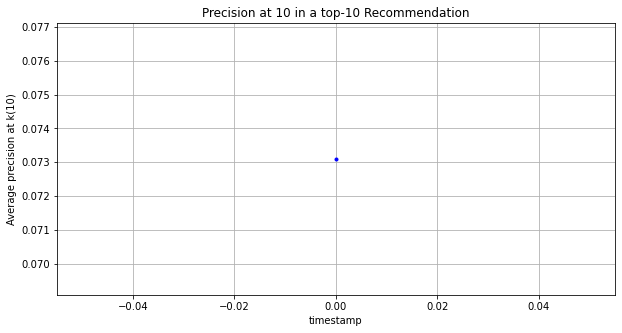

In [16]:

# Training Job Name
training_job_name = job_name

# Metric name as per the algorithm specifications
metric_name = "p@k(10)"
# Retrieve the Training job details and build a plot
metrics_dataframe = TrainingJobAnalytics(
    training_job_name=training_job_name, metric_names=[metric_name]
).dataframe()
plt = metrics_dataframe.plot(
    title="Precision at 10 in a top-10 Recommendation",
    grid=True,
    kind="line",
    figsize=(10, 5),
    x="timestamp",
    y="value",
    style="b.",
    legend=False,
)
plt.set_ylabel("Average precision at k(10)");


In [17]:

# Take Customer ID: 13085 for our analysis from the original dataset
sample_customer_id = 13085
# Let us present the top 10 original purchase history for this customer.
display_original_purchase_history(online_retail_data, sample_customer_id, 10)

**[ Top 10 Original Purchase History ] for a Customer ID : 13085**

CustomerID,StockCode,Description,Quantity,Invoice,InvoiceDate
13085,1634011558853,Furniture Set for sale,12,489434,2009-12-01 07:45:00
13085,1634011559093,Bed Room Set for sale,12,489434,2009-12-01 07:45:00
13085,1634011559259,6by6 Teak Box Bed with Hybrids Mattress for sale,12,489434,2009-12-01 07:45:00
13085,1634011559590,New Spring Mattress for sale,48,489434,2009-12-01 07:45:00
13085,1634011559751,Exclusive 6 by Teak Box Bed with Spring Mattress for sale,24,489434,2009-12-01 07:45:00
13085,1634011559907,Tv Stand for sale,24,489434,2009-12-01 07:45:00
13085,1634011560082,Exclusive 6 by 5 Teak Box Bed with Spring Mattress for sale,24,489434,2009-12-01 07:45:00
13085,1634011560266,New Phoenix 6 Pc Drawer Set for sale,10,489434,2009-12-01 07:45:00
13085,1634011560797,Exclusive 6 by Teak Box Bed for sale,12,489435,2009-12-01 07:46:00
13085,1634011561104,Tv Stand for sale,12,489435,2009-12-01 07:46:00


In [18]:

# Build a local work dir where you would create the batch transform request file in a JSON format
# Populate the requested file with the preceding example users.
with open(batch_request_data_file, "w") as outfile:
    json.dump({"user_id": str(sample_customer_id), "top_n": "10"}, outfile)
    outfile.write("\n")
outfile.close()



In [19]:
# Print the head of the payload file
!head {batch_request_data_file}


{"user_id": "13085", "top_n": "10"}


In [20]:
# Build Transform Job Name
timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
transform_job_name = transform_job_name_prefix + timestamp
transform_job_inference_path = "{}/{}".format(s3_batch_input_dir_prefix, transform_job_name)
transform_job_inference_output = "s3://" + s3_bucket + "/" + transform_job_inference_path

# Upload the batch transform request JSON file dataset to Amazon S3 buket
uploaded_batch_inference_request = sagemaker_session.upload_data(
    batch_request_data_file, s3_bucket, key_prefix=transform_job_inference_path
)
print("[INFO] S3 batch requests data location " + uploaded_batch_inference_request)


[INFO] S3 batch requests data location s3://sagemaker-us-east-1-170631572115/sagemaker/implicit-bpr/batch-inference/jobs/implicit-bpr-online-retail-batch-transform-2022-12-21-15-39-54/recommendation.requests


In [21]:

# Build the Transformer Object with the parameters
print("[INFO] Starting the batch transform job: " + transform_job_name)
transformer = estimator.transformer(
    instance_count=1,
    instance_type= compatible_batch_transform_instance_type,
    strategy="SingleRecord",
    output_path=transform_job_inference_output,
    assemble_with="Line",
    accept="text/csv",
)
# Strat the Transformer Job
transformer.transform(
    data=uploaded_batch_inference_request,
    job_name=transform_job_name,
    content_type="application/json",
    compression_type="None",
    split_type="Line",
    logs=False,
)

# Wait until the job completes
transformer.wait()
print(
    "[INFO] The batch transform job has been completed, and the output has been saved to : "
    + transformer.output_path
)


[INFO] Starting the batch transform job: implicit-bpr-online-retail-batch-transform-2022-12-21-15-39-54
...........
.......................................................!
.[INFO] The batch transform job has been completed, and the output has been saved to : s3://sagemaker-us-east-1-170631572115/sagemaker/implicit-bpr/batch-inference/jobs/implicit-bpr-online-retail-batch-transform-2022-12-21-15-39-54


In [22]:
parsed_url = urlparse(transformer.output_path)
bucket_name = parsed_url.netloc
file_key = "{}/{}.out".format(parsed_url.path[1:], s3_batch_request_file_name)


response = boto_s3_client.get_object(Bucket=sagemaker_session.default_bucket(), Key=file_key)
s3_response_bytes = response["Body"].read().decode("utf-8")

print(s3_response_bytes)

13085,1634015961949,2.940277338027954
13085,1634015998554,2.6612768173217773
13085,1634011559907,2.6541554927825928
13085,1634015961774,2.6007392406463623
13085,1634012154975,2.5661213397979736
13085,1634013463077,2.378998279571533
13085,1634015260023,2.3211793899536133
13085,1634020142256,2.2802462577819824
13085,1634021066414,2.270092487335205
13085,1634016081875,2.248026132583618



In [23]:

# Read the Batch transform response and create a Panda's Dataframe for more useful visualization.
batch_inference_response = StringIO(s3_response_bytes)

recommendations_df = pd.read_csv(
    batch_inference_response, header=None, names=["CustomerID", "StockCode", "Recommendation Score"]
)

# Model inference result to associate and endorse our predictions
display_inference_result(recommendations_df, sample_customer_id, "batch")

**[ Batch Transform ] Recommended Items with the Ranking for a Customer ID : 13085**

CustomerID,StockCode,Description,Recommendation Score
13085,1634015961949,New 4x2 Dark Office Table for sale,2.940277
13085,1634015998554,Luxury Sofa Set for sale,2.661277
13085,1634011559907,Tv Stand for sale,2.654155
13085,1634015961774,Melamine Classic Dressing Tabel for sale,2.600739
13085,1634012154975,Sofa Set with Coffee Table for sale,2.566121
13085,1634013463077,Steel Bed W D/L Mattress for sale,2.378998
13085,1634015260023,Teak dining table with 4 chairs 3x3 - tdtc203 for sale,2.321179
13085,1634020142256,Table for sale,2.280246
13085,1634021066414,Drawer Cupboard for sale,2.270092
13085,1634016081875,Two Door Cupboard for sale,2.248026


In [27]:
# Creates the deployable model, configures the SageMaker hosting services endpoint, and launches the endpoint to host the model.
compatible_real_time_inference_instance_type = "ml.c5.2xlarge"

predictor = estimator.deploy(
    1, compatible_real_time_inference_instance_type, serializer=json_serializer
)
print("[INFO] The model endpoint has been deployed successfully")


..........
-----------![INFO] The model endpoint has been deployed successfully


In [28]:
example_customer_id = 17519
# Let us present the top 10 original purchase history for this customer.
display_original_purchase_history(online_retail_data, example_customer_id, 10)

**[ Top 10 Original Purchase History ] for a Customer ID : 17519**

CustomerID,StockCode,Description,Quantity,Invoice,InvoiceDate
17519,1634011935557,teakwood dressing table code 3057 for sale,12,489445,2009-12-01 09:57:00
17519,1634011935745,neo almari glass 2D 15 bord code 3056 for sale,12,489445,2009-12-01 09:57:00
17519,1634011896912,6x5 ft spring matterss and box bed code 3070 for sale,24,489445,2009-12-01 09:57:00
17519,1634011822469,Teak Dining Table with 6 Chairs for sale,12,489445,2009-12-01 09:57:00
17519,1634011935925,1st quality teakwood sofa set code 3055 for sale,2,489445,2009-12-01 09:57:00
17519,1634011936116,no1 quality teakwood sofa set code 3054 for sale,12,489445,2009-12-01 09:57:00
17519,1634011936303,n1 piyestra original cupboard code 3052 for sale,6,489445,2009-12-01 09:57:00
17519,1634011936490,6x3 ft underlocker 2 melamine cupboard code 3051 for sale,48,489445,2009-12-01 09:57:00
17519,1634011936640,6x3 ft melamine cupboard (fully doors) code 3050 for sale,12,489445,2009-12-01 09:57:00
17519,1634011936797,Dining Table with Chairs for sale,12,489445,2009-12-01 09:57:00


In [34]:

response_dict = ""
top_n = 10

# Build the JSON Inference request
json_inference_request = {"user_id": str(example_customer_id), "top_n": str(top_n)}
# Make an Inference Request to the deployed Endpoint
response = boto3_sm_runtime.invoke_endpoint(
    EndpointName=predictor.endpoint,
    Body=json.dumps(json_inference_request),
    ContentType="application/json",
)
inference_response_body = response["Body"].read().decode("utf-8")
response_dict = eval(inference_response_body)
print("[INFO] JSON Response received from SageMaker Model Endpoint: ")
display(response_dict)


The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


[INFO] JSON Response received from SageMaker Model Endpoint: 


[{'user_id': '17519', 'item_id': '1634019738700', 'score': 3.5509696007},
 {'user_id': '17519', 'item_id': '1634019737758', 'score': 3.202539444},
 {'user_id': '17519', 'item_id': '1634018062871', 'score': 3.1720252037},
 {'user_id': '17519', 'item_id': '1634017121001', 'score': 3.0972342491},
 {'user_id': '17519', 'item_id': '1634011936797', 'score': 3.0857162476},
 {'user_id': '17519', 'item_id': '1634013367094', 'score': 3.0047881603},
 {'user_id': '17519', 'item_id': '1634017847664', 'score': 2.9884800911},
 {'user_id': '17519', 'item_id': '1634020744177', 'score': 2.9565622807},
 {'user_id': '17519', 'item_id': '1634019439874', 'score': 2.9487900734},
 {'user_id': '17519', 'item_id': '1634013364623', 'score': 2.9465601444}]

In [33]:
print(predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


implicit-bpr-online-retail-training-2022-12-21-15-50-51-006


In [32]:
if len(response_dict) > 0:
    online_response_df = pd.read_json(json.dumps(response_dict))
    # Model inference result to associate and endorse our predictions
    display_inference_result(online_response_df, example_customer_id, "realtime")
else:
    print(
        "[INFO] No response received for the request with Real-Time Inference for CustomerID {}.".format(
            customer_id
        )
    )

**[ Real-Time Inference ] Recommended Items with the Ranking for a Customer ID : 17519**

CustomerID,StockCode,Description,Recommendation Score
17519,1634019738700,"3,1,1 Brand New Sofa Set (IM-111) for sale",3.550970
17519,1634019737758,table W Cupboard for sale,3.202539
17519,1634018062871,Depo Teak Heavy Modern 2 door Based Almary code 8848 for sale,3.172025
17519,1634017121001,Antique Settee Set for sale,3.097234
17519,1634011936797,Dining Table with Chairs for sale,3.085716
17519,1634013367094,Depo Teak Modern Dining Table 4 Chairs Code 9004 for sale,3.004788
17519,1634017847664,Depo Teak 3 Door Base Arch Cupboard - Tdac00023 for sale,2.988480
17519,1634020744177,Damro Computer Table for sale,2.956562
17519,1634019439874,"LATEST 72""X75"" KING SIZE CUSHION BED -SNP 7866 for sale",2.948790
17519,1634013364623,Wardrobe for sale,2.946560


In [ ]:
#cleaning
predictor.delete_model()
predictor.delete_endpoint()
estimator.delete_endpoint()


     

In [ ]:
rm -rf $DATASET_DIR $TRAINING_WORKDIR $TEST_WORKDIR $BATCH_REQUEST_WORKDIR